# Wavefield Simulations Using SPECFEM

## Notebook 1: Intro to SPECFEM2D

- This short notebook is meant to introduce new Users to SPECFEM by teaching them how to:
    1) navigate a SPECFEM2D working directory
    2) generate a 2D mesh with homogeneous halfspace model
    3) run a forward simulation to generate synthetic seismograms   
-
-  **Objective**: Understand `SPECFEM2D` and draw parallels to `SPECFEM3D` 
- These instructions should ideally be run from inside a Docker container, using Jupyter Lab (see instructions [here](https://github.com/adjtomo/adjdocs/blob/main/readmes/docker_image_install.md)).  
-----------

**Relevant Links:** 

- The **original** Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2024-5-21_scoped_uw/1_intro_specfem2d.ipynb
- SPECFEM2D GitHub Repository: https://github.com/geodynamics/specfem2d/tree/devel
- SPECFEM2D Manual: https://specfem2d.readthedocs.io/en/latest/

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


----------
## 1) SPECFEM2D Directory Tour

- Let's start by touring around the SPECFEM2D repository, which is located (in the container in)`/home/scoped/specfem2d`  
- **Note**: This directory is not the same as what you would clone from GitHub, we have removed a number of files to keep container size reasonable  

In [1]:
# Python packages we will use on our tour
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
from seisflows.tools.model import Model

# Make sure we're in the correct directory
#%cd /home/scoped/specfem2d
! ls

1_intro_specfem2d.ipynb DATA                    OUTPUT_FILES


### 1a) SPECFEM Executables in *bin/* directory

- We have already downloaded (*git clone*), configured (*./configure*) and compiled (*make all*) SPECFEM2D   
- Executables (computer instruction sets) created by the compilation step are located in the `bin/` directory  
- Each of these executables performs a different function in the package

In [2]:
# Let's have a look at the executables
! ls ../../../specfem2d/bin

xadj_seismogram               xmeshfem2D
xcheck_quality_external_mesh  xsmooth_sem
xcombine_sem                  xspecfem2D
xconvolve_source_timefunction xsum_kernels


The two most important executables we will be using today are `xmeshfem2D` and `xspecfem2D`. 
- `xmeshfem2D`: generate a numerical mesh, the skeleton of the domain upon which we run our numerical simulations   
- `xspecfem2D`: run the spectral element solver, generates synthetic seismograms for a given source and set of stations  

Some other important executables we will use in Days 2 and 3:
- `xsmooth_sem`: smoothing through convolution with a 2D Gaussian. Users define horizontal and vertical half-widths of the Gaussian  
- `xcombine_sem`: sums multiple volumetric quantities, used e.g., to sum multiple kernels together  

You can often run an executable to determine it's usage requirements:

In [ ]:
##! mpirun -n 1 bin/xcombine_sem

**NOTE**: The above code snippet will return *'Error detected, aborting MPI'...*. This is OK, and is expected when calling the executable with no arguments  

### 1b) Parameters and Simulation Data in *DATA/* directory

- *DATA/* directory contains external data and control parameters provided to SPECFEM
- The most important files are: `Par_file`, `SOURCE` and `STATIONS`
    - `Par_file`: Parameter file used to control simulation  
    - `SOURCE`: Defines source location and mechanism (e.g moment tensor, force). 
    - `STATIONS`: Defines station codes and locations (Cartesian or geographic). 


>__SOURCE NOTE__: SPECFEM2D and SPECFEM3D have a number of different types of available source files (e.g., SOURCE, FORCESOLUTION, CMTSOLUTION)  
>__STATIONS NOTE__: In SPECFEM2D, station information may also be defined directly within the `Par_file`

In [3]:
def print_pretty(text):
    """Makes it easier to distinguish print statement outputs"""
    print(f"\n{'='*80}\n {text:^80}\n{'='*80}\n")

# Look at the DATA/ directory
print_pretty("DATA/ DIRECTORY")
! ls DATA/

# Illustrates that the Par_file is an ASCII file with key-value pairs
print_pretty("PARAMETER FILE (Par_file)")
! head -38 DATA/Par_file

# The SPECFEM2D SOURCE file defines a 2D seismic source
print_pretty("SOURCE FILE (SOURCE)")
! head DATA/SOURCE
! echo "..."
! tail DATA/SOURCE

# Sometimes in SPECFEM2D, the Par_file defines station information directly
print_pretty("INTERNAL STATION DEFINITION (Par_file)")
! head -189 DATA/Par_file | tail -n 7

# However, other examples may define station information using STATIONS files, which is formatted:
print_pretty("EXTERNAL STATION DEFINITION (STATIONS)")
print("# STATION NETWORK X[m] Z[m] burial[m] elevation[m]")
! head -5 ../../../specfem2d/EXAMPLES/Tape2007/DATA/STATIONS_checker


                                 DATA/ DIRECTORY                                 

Par_file SOURCE   STATIONS

                            PARAMETER FILE (Par_file)                            

#-----------------------------------------------------------
#
# Simulation input parameters
#
#-----------------------------------------------------------

# title of job
title                           = Test of SPECFEM2D with curved interfaces

# forward or adjoint simulation
# 1 = forward, 2 = adjoint, 3 = both simultaneously
# note: 2 is purposely UNUSED (for compatibility with the numbering of our 3D codes)
SIMULATION_TYPE                 = 1
# 0 = regular wave propagation simulation, 1/2/3 = noise simulation
NOISE_TOMOGRAPHY                = 0
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.

# parameters concerning partitioning
NPROC                           = 1              # number of processes

# time step parameters
# total number of ti

### 1c) Results stored in *OUTPUT_FILES/* directory

- Outputs generated by SPECFEM are stored in the `OUTPUT_FILES/` directory  
- Outputs include: log files, error messages, synthetic seismograms, figures, database files  
- Database files store information about the mesh and model  
- **SPECFEM3D NOTE:** SPECFEM3D maintains a separate database directory (typically called `DATABASES_MPI/`).

In [ ]:
# Contains the error message from the previous command
##! ls OUTPUT_FILES

-----------
## 2) Running the Mesher (`xmeshfem2D`)  

- We will use two terms to talk about meshing:  
    - **MESH**: a numerical grid which defines coordinate points only (i.e., X and Z in 2D).  
    - **MODEL**: parameter values (e.g., seismic velocity) approximating structure, assigned to locations on the MESH.  
- The **first** thing we need to do when approaching numerical simulations is to generate a numerical mesh   
- During *this* workshop we will use SPECFEM's internal mesher, `Meshfem`. External programs exist, such as [Gmsh](https://gmsh.info/) and [Trelis](https://coreform.com/products/coreform-cubit/) 


### Mesh Examples
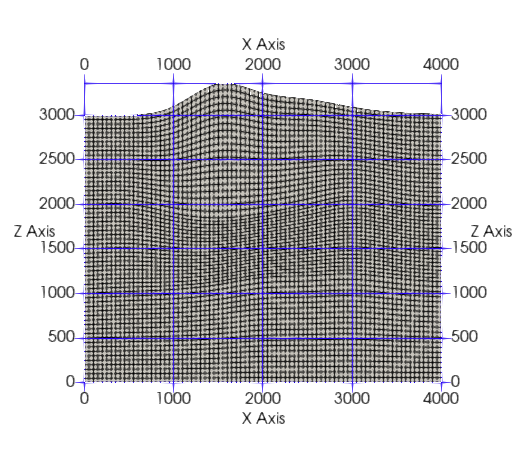
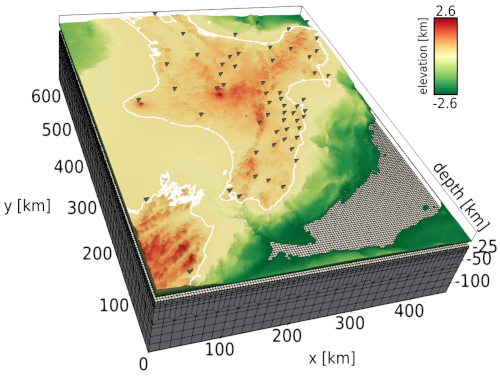


### 2a) Model Parameters

- In SPECFEM2D, *mesh* and *model* specifications are defined in the `Par_file`  
- There are a number of parameter options we can use to customize them
- In **SPECFEM3D**, mesh files are defined in a separate `Mesh_Par_file`, typically stored in `DATA/meshfem3D_files`.

In [4]:
# Incase participants get lost, each numbered section 
# contains the absolute work dir path
##%cd /home/scoped/specfem2d

# Look at the definition of the model in the Par_file
! head -298 DATA/Par_file | tail -n 28

absorbing_surface_file          = dummy                                   # file containing the absorbing surface
acoustic_forcing_surface_file   = dummy                                   # file containing the acoustic forcing surface
absorbing_cpml_file             = dummy                                   # file containing the CPML element numbers
tangential_detection_curve_file = dummy                                   # file containing the curve delimiting the velocity model

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# material properties
# number of model materials
nbmodels                        = 4
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QK

- In the output above we can see that our `Par_file` defines 4 separate regions, each with varying values for density and velocity.

```bash
N - RHO     VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.051d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.375d0 0 0 9999 9999 0 0 0 0 0 0
4 1 2200.d0 2200.d0 1343.375d0 0 0 9999 9999 0 0 0 0 0 0
```
- These regions have **no** sense of space. They only represent material properties.
- These regions will be assigned to parts of the *mesh* in the following section

### 2b) Mesh Parameters

- The internal mesher has a set of parameters that allows Users to provide: interfaces, geometry, boundary conditions.
    - **Interfaces** define the contact point between two mesh domains. Across an interface, mesh geometry and model parameters can change.
    - **Boundary conditions** define how waves interact with the edges of your finite domain. Often absorbing boundary conditions are used.
    - **Mesh geometry** can be optimized to reduce computational cost while keeping simulations stable.

In [5]:
! head -320 DATA/Par_file | tail -n 21

#       utils/attenuation/conversion_from_Qkappa_Qmu_to_Qp_Qs_from_Dahlen_Tromp_959_960.f90.
1 1 2700.d0 3000.d0 1732.051d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.375d0 0 0 9999 9999 0 0 0 0 0 0
4 1 2200.d0 2200.d0 1343.375d0 0 0 9999 9999 0 0 0 0 0 0

# file containing interfaces for internal mesh
interfacesfile                  = ../EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 4000.d0        # abscissa of right side of the model
nx                              = 80             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                    

#### Understanding Internal Mesh Parameters
- In Meshfem2D we can set any of the 4 edges to be absoring
- The top boundary is often not absoring, to mimic surface reflections as you would have in the real world
- The section at the bottom partitions *materials* defined by the model, to *regions* of the mesh
- A separate *interface* file defines the shape of boundaries within the mesh

In [3]:
# Let's have a look at the `interfaces` file which defines boundary interfaces 
! cat ../../../specfem2d//EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# number of interfaces
 4
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0 0
 5000 0
# interface number 2
 7
    0 1000
 1500 1100
 2000 1180
 2500 1200
 3000 1220
 3500 1170
 5000 1100
# interface number 3
 9
    0 2000
  500 2000
 1000 1900
 1500 1847
 2000 1900
 2500 2000
 3000 2090
 3500 2020
 5000 2000
# interface number 4 (topography, top of the mesh)
 8
    0 3000
  500 3000
 1000 3100
 1500 3350
 2000 3250
 2500 3180
 3000 3090
 5000 3000
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1 (bottom layer)
 20
# layer number 2
 20
# layer number 3 (top layer)
 20


#### Understanding Interface Files
- There are 4 interfaces defined in this file (bottom of mesh, 2 internal interfaces, top of mesh)  
- The bottom of the mesh is flat; the other 3 interfaces (including top of mesh, a.k.a topography) are curved  
- We define 20 elements in each layer for 60 total elements in the Z direction

### 2c) Setting Up Meshfem

- We need to set a few `Par_file` parameters to tell SPECFEM how to behave during meshing  
- Here, for convenience, we introduce the `SeisFlows` command line tool, which provides Python-based utility functions 
- We will use the `seisflows sempar` commmand line utility to print and edit values from the SPECFEM2D `Par_file`   

----------
**SEMPAR NOTE**: The `sempar` (spectral element method parameter) command syntax is as follows
```python
seisflows sempar -P <Par_file> <key> <value:optional>
```
- \<Par_file> is the path the SPECFEM `Par_file`
- \<key> represents a parameter in the par file (case-insensitive) 
- \<value> is an optional parameter to overwrite an existing parameter. 
--------------    

In [9]:
! seisflows sempar -P DATA/Par_file model  # <- This is a print statement
! seisflows sempar -P DATA/Par_file nproc 1 #4  # <- This is a change of variables  
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_model binary

MODEL: default
NPROC: 4 -> 1
setup_with_binary_database: 1 -> 1
SAVE_MODEL: binary -> binary


#### Meshfem Parameter Explanations

`MODEL`: Must be 'default' to use the model defined in the `Par_file` (this is the default option)  
`NPROC`: Number of MPI processes to run on. The mesh itself is partitioned into `NPROC` sections, each of which is provided to a separate processor  
`setup_with_binary_database`: Writes database files in FORTRAN Binary format, by default they are *not* saved  
`SAVE_MODEL`: Write the model out in FORTRAN Binary format. As opposed to other formats like ASCII

### 2d) Run Meshfem Executable

- SPECFEM will look for relevant data in the *DATA/* directory
- It will generate a numerical mesh in the *OUTPUT_FILES/* directory. 
- The *model* will **not** be output until we run the solver (`xspecfem2D`) later in the notebook

In [ ]:
##! ../../specfem2d/bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

In [10]:
# Run the mesher and re-direct output to a text file
##! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt
! ../../../specfem2d/bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

# The log file contains important information on how the mesher ran
! head OUTPUT_FILES/output_meshfem2d.txt
! echo "..."
! tail OUTPUT_FILES/output_meshfem2d.txt


 **********************************************
 *** Specfem 2-D Mesher - serial version    ***
 **********************************************

 Running Git version of the code corresponding to 11e23032568fce4b93b9491a4d1bb7829341b0fb
 dating 2025-01-27 20:58:02 +0100

 Reading the parameter file...

...
 Receiver           16  =    2500.0000000000000        1500.0000000000000     
 Receiver           17  =    2500.0000000000000        1250.0000000000000     
 Receiver           18  =    2500.0000000000000        1000.0000000000000     
 Receiver           19  =    2500.0000000000000        750.00000000000000     
 Receiver           20  =    2500.0000000000000        500.00000000000000     
 Receiver           21  =    2500.0000000000000        250.00000000000000     
 Receiver           22  =    2500.0000000000000        0.0000000000000000     

 This will be a serial simulation



In [11]:
# e.g., the mesher has created our STATIONS File
! head -255 OUTPUT_FILES/output_meshfem2d.txt | tail -n 34

 creating STATIONS file...

 writing the ./DATA/STATIONS file


 There are           22  receivers

 Target positions (x,z) of the           22  receivers

 Receiver            1  =    300.00000000000000        2997.7298908673174     
 Receiver            2  =    640.00000000000000        3008.0430011257899     
 Receiver            3  =    980.00000000000000        3090.8224062492818     
 Receiver            4  =    1320.0000000000000        3283.0303922802987     
 Receiver            5  =    1660.0000000000000        3347.8768862033312     
 Receiver            6  =    2000.0000000000000        3250.0000000000000     
 Receiver            7  =    2340.0000000000000        3197.3138031016656     
 Receiver            8  =    2680.0000000000000        3150.9619872716830     
 Receiver            9  =    3020.0000000000000        3086.5939051292362     
 Receiver           10  =    3360.0000000000000        3042.8523748190692     
 Receiver           11  =    3700.0000000000000       

In [12]:
# The STATIONS file matches what the log file tells us 
! cat DATA/STATIONS

S0001    AA          300.0000000         2997.7298909       0.0         0.0
S0002    AA          640.0000000         3008.0430011       0.0         0.0
S0003    AA          980.0000000         3090.8224062       0.0         0.0
S0004    AA         1320.0000000         3283.0303923       0.0         0.0
S0005    AA         1660.0000000         3347.8768862       0.0         0.0
S0006    AA         2000.0000000         3250.0000000       0.0         0.0
S0007    AA         2340.0000000         3197.3138031       0.0         0.0
S0008    AA         2680.0000000         3150.9619873       0.0         0.0
S0009    AA         3020.0000000         3086.5939051       0.0         0.0
S0010    AA         3360.0000000         3042.8523748       0.0         0.0
S0011    AA         3700.0000000         3020.6886768       0.0         0.0
S0012    AA         2500.0000000         2500.0000000       0.0         0.0
S0013    AA         2500.0000000         2250.0000000       0.0         0.0
S0014    AA 

In [13]:
# Database files are stored in the OUTPUT_FILES/ directory as FORTRAN binary (.bin) files
! ls OUTPUT_FILES/Database*.bin

OUTPUT_FILES/Database00000.bin


In [14]:
# SPECFEM also outputs Visualization Toolkit (.vtk) files which
# can be used for visualization using external software
! ls OUTPUT_FILES/*.vtk

OUTPUT_FILES/mesh00000_rho.vtk         OUTPUT_FILES/mesh_materials.vtk
OUTPUT_FILES/mesh00000_vp.vtk          OUTPUT_FILES/mesh_partition_number.vtk
OUTPUT_FILES/mesh00000_vs.vtk


---------
## 3) Running the Solver `xspecfem2D`

- The Solver `xspecfem2D` will now take the Database files generated by `xmeshfem2D` and run a wave propagation simulation  
- `xspecfem2D` uses the provided `SOURCE` to initiate a force in the domain  
- The propagating wavefield is simulated across the **entire** domain  
- The `STATIONS` files tells SPECFEM where to **store** waveforms generated by the propagating wavefield
- These files are **synthetic seismograms** and mimic real-world recordings made by seismometers  

![wavefield gif](https://user-images.githubusercontent.com/23055374/193936208-6ec5fbe6-dfed-41f1-945e-ede9f737a0ea.gif)

*Example 3D wavefield simulation (wavefield shown at the surface) illustrating the wavefield being simulated throughout the domain, whereas stations define point recordings of the wavefield*

In [15]:
##%cd /home/scoped/specfem2d

# Let's look at some Solver-specific parameters
! head -171 DATA/Par_file | tail -n 32

# (in DATA folder by default). Then you rerun the code and it will read the databases in there directly possibly
# saving a lot of time.
# This is only useful for GPU version (for now)
write_moving_sources_database   = .false.

#-----------------------------------------------------------
#
# Receivers
#
#-----------------------------------------------------------

# receiver set parameters for recording stations (i.e. recording points)
# seismotype : record 1=displ 2=veloc 3=accel 4=pressure 5=curl of displ 6=the fluid potential 7=electric field
seismotype                      = 1              # several values can be chosen. For example : 1,2,4

# interval in time steps for writing of seismograms
# every how many time steps we save the seismograms
# (costly, do not use a very small value; if you use a very large value that is larger than the total number
#  of time steps of the run, the seismograms will automatically be saved once at the end of the run anyway)
NTSTEP_BETWEEN_OUTPUT_SEI

### Some Important Solver Parameters

- `seismotype`: Set units of the output synthetic seismograms. Here we output 'displacement' in SI unit meters  
- `USER_T0`: Defines the earlist starting time is, prior to time step 0. This allows some zero padding before initiating the source  
- `save_ASCII_seismograms`: Outputs seismograms in two-column ASCII files, as opposed to binary or Seismic Unix format    

In [16]:
# Run the solver on 4 cores, re-direct output log
##! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt
! ../../../specfem2d/bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

# Again, the log file contains important information on the process
! head OUTPUT_FILES/output_solver.txt
! echo "..."
! tail OUTPUT_FILES/output_solver.txt


 **********************************************
 **** Specfem 2-D Solver - serial version  ****
 **********************************************

 Running Git version of the code corresponding to 11e23032568fce4b93b9491a4d1bb7829341b0fb
 dating 2025-01-27 20:58:02 +0100


 NDIM =            2
...
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 12 - 02 - 2025                                 T i m e  : 14:37:38
 -------------------------------------------------------------------------------
 --------------------------------------------------------------------------

In [17]:
# Mesh and Model parameters are assigned here
! head -282 OUTPUT_FILES/output_solver.txt | tail -n 16

   MODEL                   : default
   nspec                   :         4800
   external velocity model :  F

   setting up material arrays

   rho : min/max =    2200.00000     /   2700.00000    
   vs  : min/max =    0.00000000     /   1732.05103    
   vp  : min/max =    2200.00000     /   3000.00000    

   all material arrays done

   written file: ./OUTPUT_FILES/mesh00000_vs.vtk
   written file: ./OUTPUT_FILES/mesh00000_vp.vtk
   written file: ./OUTPUT_FILES/mesh00000_rho.vtk



In [18]:
# During the simulation, the log file updates the User on progress
! head -1053 OUTPUT_FILES/output_solver.txt | tail -n 32



 ******************************************************************
 Time step #     500 out of    1600
 ******************************************************************
 Time:    0.4289 s
 We have done    31.2070045     % of the total
 Max norm of vector field in solid (elastic) =    9.34773162E-02
 Max absolute value of scalar field in fluid (acoustic) =    5218.37256    
 Elapsed time in seconds =    1.9149999618530273     
 Elapsed time in hh:mm:ss =      0 h 00 m 01 s
 Mean elapsed time per time step in seconds =    3.8299999237060545E-003
 Time steps remaining =         1100
 Estimated remaining time in seconds =    4.2129999160766598     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 04 s
 Estimated total run time in seconds =    6.1279998779296871     
 Estimated total run time in hh:mm:ss =      0 h 00 m 06 s
 The run will finish approximately on: Wed Feb 12, 2025 14:38


 Writing PostScript vector plot for time step          500
 drawing displacement vector as sma

In [19]:
# The solver writes out model files at the end of the simulation
! tail -n 25 OUTPUT_FILES/output_solver.txt


 Saving model files to directory: ./DATA/
   SAVE_MODEL type: binary

   written to file(s): ./DATA/proc000000_x.bin
   written to file(s): ./DATA/proc000000_z.bin
   written to file(s): ./DATA/proc000000_jacobian.bin
   written to file(s): ./DATA/proc000000_rho.bin
   written to file(s): ./DATA/proc000000_vp.bin
   written to file(s): ./DATA/proc000000_vs.bin

   done


 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 12 - 02 - 2025                                 T i m e  : 14:37:3

-------------
## 4) Understanding SPECFEM2D Output Files

- `xspecfem2D` has created a number of output files
- These files include a log message, additional DATABASE files, synthetic seismograms, and the output model

In [ ]:
##%cd /home/scoped/specfem2d

# For example, the DATA/*.bin files define our velocity model
! ls DATA/*bin

### 4a) Velocity Model

- `xspecfem2D` outputs the velocity model to the *DATA/* directory  
- We can use some SeisFlows utility functions to plot this model to help us visualize our domain  
- **SPECFEM3D NOTE**: SPECFEM3D outputs velocity model files to the `Par_file` parameter `LOCAL_PATH`, commonly `OUTPUT_FILES/DATABASES_MPI`

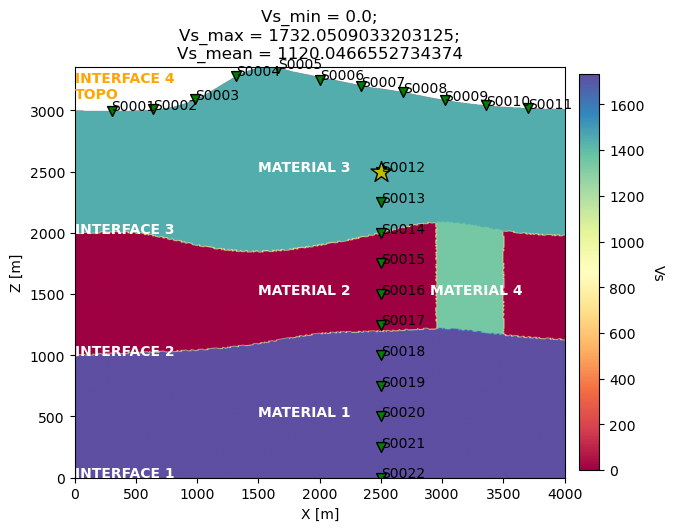

In [20]:
def plot_velocity_model():
    """Convenience function to plot velocity model with sources and stations"""
    # Grab STATION coordinates by reading ACSII files
    sta_x, sta_z = np.genfromtxt("DATA/STATIONS", dtype=float, usecols=[2, 3]).T
    sta_id = np.genfromtxt("DATA/STATIONS", dtype=str, usecols=[0]).T

    # Grab SOURCE coordinates from SOURCE file
    source_file = f"DATA/SOURCE"
    with open(source_file, "r") as f:
        lines = f.readlines()

    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    ev_x = float(lines[2].split("=")[1].split("#")[0].strip())
    ev_z = float(lines[3].split("=")[1].split("#")[0].strip())

    # Use SeisFlows 'Model' class to plot the 2D model 
    m = Model(path="DATA")
    m.plot2d(parameter="vs", show=False)

    # Plot SOURCE and STATIONS on top of the model
    for x_, z_, id_ in zip(sta_x, sta_z, sta_id):
        plt.scatter(float(x_), float(z_), c="g", marker="v", ec="k", s=50)
        plt.text(x_, z_, id_)
    plt.scatter(ev_x, ev_z, c="y", marker="*", ec="k", s=250)
    
    # Plot interface text labels for educational purposes
    plt.text(0, 0, "INTERFACE 1", c="w", weight="bold", size=10)
    plt.text(0, 1000, "INTERFACE 2", c="w", weight="bold", size=10)
    plt.text(0, 2000, "INTERFACE 3", c="w", weight="bold", size=10)
    plt.text(0, 3100, "INTERFACE 4\nTOPO", c="orange", weight="bold", size=10)
    
    # Plot material text labels for educational purposes
    plt.text(1500, 500, "MATERIAL 1", c="w", weight="bold", size=10)
    plt.text(1500, 1500, "MATERIAL 2", c="w", weight="bold", size=10)
    plt.text(1500, 2500, "MATERIAL 3", c="w", weight="bold", size=10)
    plt.text(2900, 1500, "MATERIAL 4", c="w", weight="bold", size=10)
    
plot_velocity_model()

- The model above shows shear wave velocities (Vs in m/s) in a 2D domain
- Our model is defined by 3 distinct layers (compare to interfaces file previously). 
    - Top: Z=3500m to Z=2000m, features a moderate velocity with topography at the surface (Z>3000m). 
    - Middle: Z=2000m to Z=1000m shows a low velocity zone with a high-velocity column (turquoise square). 
    - Bottom: Z=1000m to Z=0m, features a realtively fast velocity. 
- 22 Station locations (green triangles), along the top boundary, and in a 'borehole' below the event
- 1 event (yellow star) colocated with station S0012

----------
We can check the material properties against those defined in the `Par_file`
```bash
N - RHO     VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.051d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.375d0 0 0 9999 9999 0 0 0 0 0 0
4 1 2200.d0 2200.d0 1343.375d0 0 0 9999 9999 0 0 0 0 0 0
```

In [21]:
# We can compare the interface file with the mesh above
! head -39 EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat | tail -n 34

# interface number 1 (bottom of the mesh)
 2
 0 0
 5000 0
# interface number 2
 7
    0 1000
 1500 1100
 2000 1180
 2500 1200
 3000 1220
 3500 1170
 5000 1100
# interface number 3
 9
    0 2000
  500 2000
 1000 1900
 1500 1847
 2000 1900
 2500 2000
 3000 2090
 3500 2020
 5000 2000
# interface number 4 (topography, top of the mesh)
 8
    0 3000
  500 3000
 1000 3100
 1500 3350
 2000 3250
 2500 3180
 3000 3090
 5000 3000


### 4b) Synthetic waveforms

- During the simulation, `xspecfem2D` initiated the `SOURCE` file at time T=0  
- Over the course of the simulation, seismic waves propogated outward and were recorded at receiver locations defined by `STATIONS`   
- Each `STATION` has a corresponding synthetic seismogram located in the *OUTPUT_FILES/* directory.

#### Synthetic Filename Formats
- Synthetic seismograms have file extension `.semd` because they are output in displacement (set by parameter `seismotype`)  
- 'd' in .semd stands for **d**isplacement. Velocity seismograms would be extension'ed `.semv`, acceleration `.sema`. **This is the same in SPECFEM3D**
- For simplicity we have chosen to output our synthetics in ACSII format. These ASCII files are two columns, representing time and amplitude, respectively.

In [22]:
# We have generated synthetics for each station location shown above
! ls OUTPUT_FILES/*.semd
! echo

# The first 10 lines of a seismogram show the two-column (time, amplitude) format
! head -10 OUTPUT_FILES/AA.S0001.BXX.semd

OUTPUT_FILES/AA.S0001.BXX.semd OUTPUT_FILES/AA.S0012.BXX.semd
OUTPUT_FILES/AA.S0001.BXZ.semd OUTPUT_FILES/AA.S0012.BXZ.semd
OUTPUT_FILES/AA.S0002.BXX.semd OUTPUT_FILES/AA.S0013.BXX.semd
OUTPUT_FILES/AA.S0002.BXZ.semd OUTPUT_FILES/AA.S0013.BXZ.semd
OUTPUT_FILES/AA.S0003.BXX.semd OUTPUT_FILES/AA.S0014.BXX.semd
OUTPUT_FILES/AA.S0003.BXZ.semd OUTPUT_FILES/AA.S0014.BXZ.semd
OUTPUT_FILES/AA.S0004.BXX.semd OUTPUT_FILES/AA.S0015.BXX.semd
OUTPUT_FILES/AA.S0004.BXZ.semd OUTPUT_FILES/AA.S0015.BXZ.semd
OUTPUT_FILES/AA.S0005.BXX.semd OUTPUT_FILES/AA.S0016.BXX.semd
OUTPUT_FILES/AA.S0005.BXZ.semd OUTPUT_FILES/AA.S0016.BXZ.semd
OUTPUT_FILES/AA.S0006.BXX.semd OUTPUT_FILES/AA.S0017.BXX.semd
OUTPUT_FILES/AA.S0006.BXZ.semd OUTPUT_FILES/AA.S0017.BXZ.semd
OUTPUT_FILES/AA.S0007.BXX.semd OUTPUT_FILES/AA.S0018.BXX.semd
OUTPUT_FILES/AA.S0007.BXZ.semd OUTPUT_FILES/AA.S0018.BXZ.semd
OUTPUT_FILES/AA.S0008.BXX.semd OUTPUT_FILES/AA.S0019.BXX.semd
OUTPUT_FILES/AA.S0008.BXZ.semd OUTPUT_FILES/AA.S0019.BXZ.semd
OUTPUT_F

Text(0, 0.5, 'Displacement [m]')

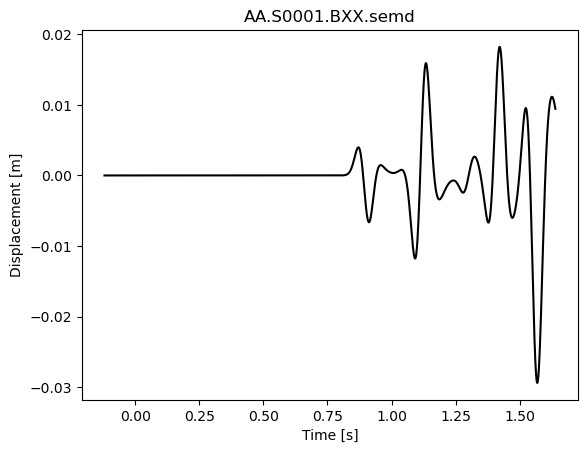

In [23]:
# Plot seismograms using NumPy and Matplotlib
data = np.loadtxt("OUTPUT_FILES/AA.S0001.BXX.semd", dtype=float)

plt.plot(data[:,0], data[:,1], c="k")
plt.title("AA.S0001.BXX.semd")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

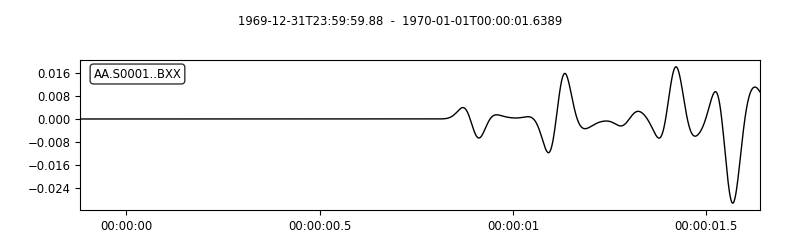

In [24]:
# SeisFlows also has a simple command line tool to plot seismograms using ObsPy
! seisflows plotst OUTPUT_FILES/AA.S0001.BXX.semd --savefig AA.S0001.BXX.semd.png
Image("AA.S0001.BXX.semd.png")

### 4c) SPECFEM2D Wavefield Snapshots 

- `xspecfem2D` generates JPEG snapshots of the forward wavefield during a simulation  
- This is specific to SPECFEM2D, for **SPECFEM3D**, you will need to output data arrays of each snapshot, which are visualized separately  
- The `Par_file` parameter `NTSTEP_BETWEEN_OUTPUT_IMAGES` controls how often figures are generated during a simulation. 
- We can see below that `DT`=.0011, so we output images every 0.11s of simulation time. 

In [26]:
# Use sempar to display parameter values
! seisflows sempar -P DATA/Par_file ntstep_between_output_images
! seisflows sempar -P DATA/Par_file dt

NTSTEP_BETWEEN_OUTPUT_IMAGES: 100
DT: 0.0011


In [27]:
# Wavefield snapshots every 100 time steps
! ls OUTPUT_FILES/*.jpg

OUTPUT_FILES/forward_image000000005.jpg OUTPUT_FILES/forward_image000000900.jpg
OUTPUT_FILES/forward_image000000100.jpg OUTPUT_FILES/forward_image000001000.jpg
OUTPUT_FILES/forward_image000000200.jpg OUTPUT_FILES/forward_image000001100.jpg
OUTPUT_FILES/forward_image000000300.jpg OUTPUT_FILES/forward_image000001200.jpg
OUTPUT_FILES/forward_image000000400.jpg OUTPUT_FILES/forward_image000001300.jpg
OUTPUT_FILES/forward_image000000500.jpg OUTPUT_FILES/forward_image000001400.jpg
OUTPUT_FILES/forward_image000000600.jpg OUTPUT_FILES/forward_image000001500.jpg
OUTPUT_FILES/forward_image000000700.jpg OUTPUT_FILES/forward_image000001600.jpg
OUTPUT_FILES/forward_image000000800.jpg


At time step 300 (T=0.33s), we can see the P- and S-wave wavefronts (alternative red and blue) radiating from the source location  

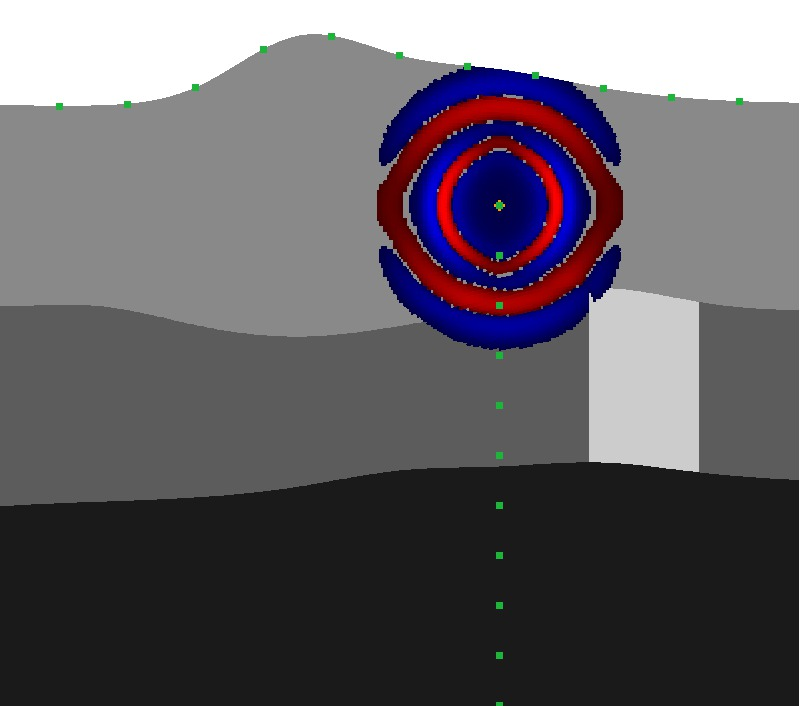

In [28]:
Image("OUTPUT_FILES/forward_image000000300.jpg")

At time step 500 (T=0.55s), we can see the P-wavefront reflect off the surface (top boundary).   
We can also see the failure of the S-wave to propagate into Material 2 (middle layer); instead, converted phases are seen propagating through  

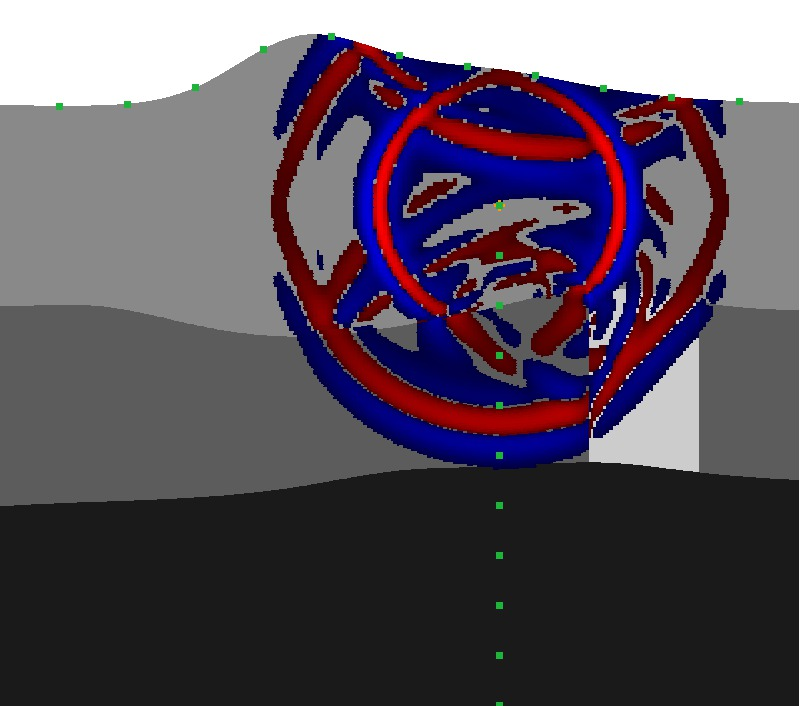

In [29]:
Image("OUTPUT_FILES/forward_image000000500.jpg")

At time step 900 (T=0.99s), the wavefield is complex, reflections off internal boundaries are visibile throughout.  
Most notably we can see the absorbing boundary conditions on the bottom and right boundaries.  
Station 22 (lowest green square) is completely inside the absorbing boundary, and consequently has a 0 amplitude waveform.  

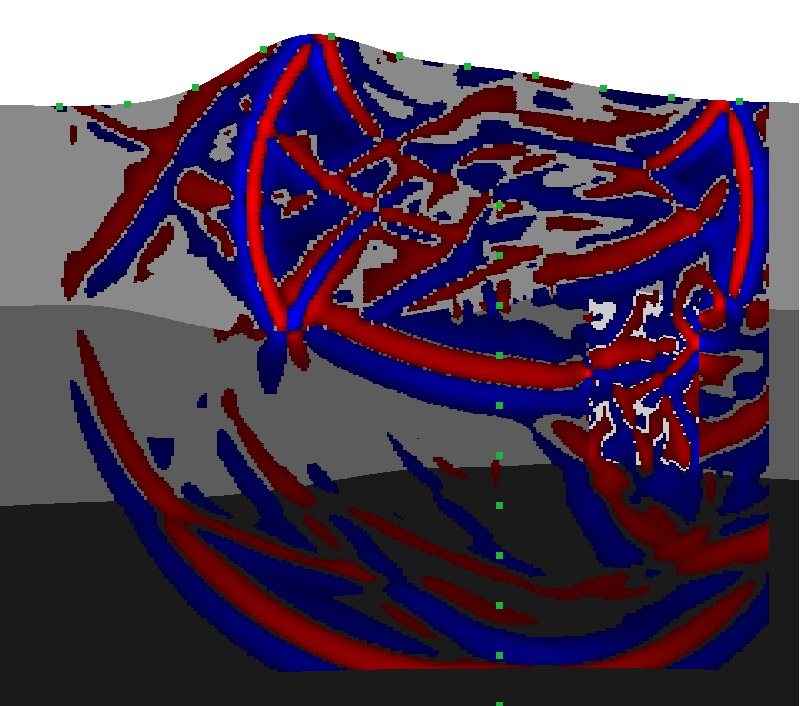

In [30]:
Image("OUTPUT_FILES/forward_image000000900.jpg")

## Generate an Animation of the Wavefield

We use `ffmpeg` to generate a video file in `mp4` format.

In [36]:
! /Applications/ffmpeg -framerate 9 -pattern_type glob -i './OUTPUT_FILES/forward_image*.jpg' out.mp4

ffmpeg version 7.1-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.3)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libharfbuzz --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-c

### Display the video

Using an html snippet, we can display the video directly in the notebook.

See also the animation tutorials.

In [4]:
%%html
<video controls loop width="640" height="480">
  <source src="./out.mp4" type="video/mp4" />

-------------
## 5) Conclusions

- In this notebook we explored SPECFEM2D, and learned to run the default example mesh generation and forward simulation.  
- We took a look at the most important files required for a simulation, and how User's can manipulate various parameters and files to run their own simulations. 
- We had a look at the results of a SPECFEM2D simulation, including waveforms, models, and wavefield snapshots.



In [40]:
%%html
<font size=10 color='hotpink'>Hello World</font>